In [189]:
import numpy as np
import itertools
from scipy.special import comb
from scipy.linalg import subspace_angles
from scipy.optimize import minimize
from sklearn.cluster import SpectralClustering
import pandas as pd
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml

In [6]:
def single_cPCA(X:np.ndarray, Y:np.ndarray, alpha, k):
    Cx = np.cov(X.T)
    Cy = np.cov(Y.T)

    C = Cx - alpha * Cy
    _, V = np.linalg.eigh(C)

    return V[:, -k:]

In [99]:
def affinity(combination, d, k):
    combination = combination.reshape(2, d, k)
    return np.prod(np.cos(subspace_angles(*combination)))

def v_affinity(combinations, d, k):
    return np.apply_along_axis(lambda combination: affinity(combination, d, k), 1, combinations)

In [97]:
def cPCA(X:np.ndarray, Y:np.ndarray, alpha_set, k, p):
    # check d value:
    assert X.shape[1] == Y.shape[1]

    d = X.shape[1]
    V_set = []

    # calculate cPCA for each alpha
    for alpha in alpha_set:
        V = single_cPCA(X, Y, alpha, k)
        V_set.append(V)
    V_set = np.array(V_set)

    # calculate affinity Matrix for each pair of Vs
    combination_indices = np.array(list(itertools.combinations_with_replacement(range(len(V_set)), 2)))
    combinations = V_set[combination_indices].reshape(len(combination_indices), 2 * d * k)
    aff = v_affinity(combinations, d, k)

    rows = combination_indices[:, 0]
    cols = combination_indices[:, 1]
    D = np.zeros((len(V_set), len(V_set)))
    D[rows, cols] = D[cols, rows] = aff

    # cluster Vs with respect to affinities
    clustering = SpectralClustering(n_clusters=p, affinity='precomputed').fit(D)

    # find best V and alpha in each cluster
    V_star = np.zeros((p, d, k))
    alpha_star = np.zeros(p)
    for cluster in range(p):
        cluster_members = np.where(clustering.labels_ == cluster)[0]
        sums = np.sum(D[cluster_members, :][:, cluster_members], axis=1)
        V_star[cluster] = V_set[cluster_members[np.argmax(sums)]]
        alpha_star[cluster] = alpha_set[cluster_members[np.argmax(sums)]]
    
    return alpha_star, V_star

In [296]:
n = 1000
m = 100
d = 50
k = 20
p = 2

In [297]:
X = np.random.uniform(-10, 10, (n, d))
X.shape

(1000, 50)

In [298]:
Y = np.random.uniform(-10, 10, (m, d))
Y.shape

(100, 50)

In [302]:
alpha_set = np.arange(0.01, 1, 0.03)
alpha_set.shape

(33,)

In [306]:
alpha_star, V_star = cPCA(X, Y, alpha_set, k, p)

In [307]:
V_star.shape

(2, 50, 20)

In [308]:
alpha_star.shape

(2,)

Dataset description is available [here](https://archive.ics.uci.edu/ml/datasets/Mice+Protein+Expression).

In [74]:
dataset = pd.read_excel('https://archive.ics.uci.edu/ml/machine-learning-databases/00342/Data_Cortex_Nuclear.xls')
dataset.head()

,MouseID,DYRK1A_N,ITSN1_N,BDNF_N,NR1_N,NR2A_N,pAKT_N,pBRAF_N,pCAMKII_N,pCREB_N,pELK_N,pERK_N,pJNK_N,PKCA_N,pMEK_N,pNR1_N,pNR2A_N,pNR2B_N,pPKCAB_N,pRSK_N,AKT_N,BRAF_N,CAMKII_N,CREB_N,ELK_N,ERK_N,GSK3B_N,JNK_N,MEK_N,TRKA_N,RSK_N,APP_N,Bcatenin_N,SOD1_N,MTOR_N,P38_N,pMTOR_N,DSCR1_N,AMPKA_N,NR2B_N,...,TIAM1_N,pP70S6_N,NUMB_N,P70S6_N,pGSK3B_N,pPKCG_N,CDK5_N,S6_N,ADARB1_N,AcetylH3K9_N,RRP1_N,BAX_N,ARC_N,ERBB4_N,nNOS_N,Tau_N,GFAP_N,GluR3_N,GluR4_N,IL1B_N,P3525_N,pCASP9_N,PSD95_N,SNCA_N,Ubiquitin_N,pGSK3B_Tyr216_N,SHH_N,BAD_N,BCL2_N,pS6_N,pCFOS_N,SYP_N,H3AcK18_N,EGR1_N,H3MeK4_N,CaNA_N,Genotype,Treatment,Behavior,class
0,309_1,0.503644,0.747193,0.430175,2.816329,5.990152,0.218830,0.177565,2.373744,0.232224,1.750936,0.687906,0.306382,0.402698,0.296927,1.022060,0.605673,1.877684,2.308745,0.441599,0.859366,0.416289,0.369608,0.178944,1.866358,3.685247,1.537227,0.264526,0.319677,0.813866,0.165846,0.453910,3.037621,0.369510,0.458539,0.335336,0.825192,0.576916,0.448099,0.586271,...,0.482864,0.294170,0.182150,0.842725,0.192608,1.443091,0.294700,0.354605,1.339070,0.170119,0.159102,0.188852,0.106305,0.144989,0.176668,0.125190,0.115291,0.228043,0.142756,0.430957,0.247538,1.603310,2.014875,0.108234,1.044979,0.831557,0.188852,0.122652,NaN,0.106305,0.108336,0.427099,0.114783,0.131790,0.128186,1.675652,Control,Memantine,C/S,c-CS-m
1,309_2,0.514617,0.689064,0.411770,2.789514,5.685038,0.211636,0.172817,2.292150,0.226972,1.596377,0.695006,0.299051,0.385987,0.281319,0.956676,0.587559,1.725774,2.043037,0.445222,0.834659,0.400364,0.356178,0.173680,1.761047,3.485287,1.509249,0.255727,0.304419,0.780504,0.157194,0.430940,2.921882,0.342279,0.423560,0.324835,0.761718,0.545097,0.420876,0.545097,...,0.454519,0.276431,0.182086,0.847615,0.194815,1.439460,0.294060,0.354548,1.306323,0.171427,0.158129,0.184570,0.106592,0.150471,0.178309,0.134275,0.118235,0.238073,0.142037,0.457156,0.257632,1.671738,2.004605,0.109749,1.009883,0.849270,0.200404,0.116682,NaN,0.106592,0.104315,0.441581,0.111974,0.135103,0.131119,1.743610,Control,Memantine,C/S,c-CS-m
2,309_3,0.509183,0.730247,0.418309,2.687201,5.622059,0.209011,0.175722,2.283337,0.230247,1.561316,0.677348,0.291276,0.381002,0.281710,1.003635,0.602449,1.731873,2.017984,0.467668,0.814329,0.399847,0.368089,0.173905,1.765544,3.571456,1.501244,0.259614,0.311747,0.785154,0.160895,0.423187,2.944136,0.343696,0.425005,0.324852,0.757031,0.543620,0.404630,0.552994,...,0.447197,0.256648,0.184388,0.856166,0.200737,1.524364,0.301881,0.386087,1.279600,0.185456,0.148696,0.190532,0.108303,0.145330,0.176213,0.132560,0.117760,0.244817,0.142445,0.510472,0.255343,1.663550,2.016831,0.108196,0.996848,0.846709,0.193685,0.118508,NaN,0.108303,0.106219,0.435777,0.111883,0.133362,0.127431,1.926427,Control,Memantine,C/S,c-CS-m
3,309_4,0.442107,0.617076,0.358626,2.466947,4.979503,0.222886,0.176463,2.152301,0.207004,1.595086,0.583277,0.296729,0.377087,0.313832,0.875390,0.520293,1.566852,2.132754,0.477671,0.727705,0.385639,0.362970,0.179449,1.286277,2.970137,1.419710,0.259536,0.279218,0.734492,0.162210,0.410615,2.500204,0.344509,0.429211,0.330121,0.746980,0.546763,0.386860,0.547849,...,0.442650,0.398534,0.161768,0.760234,0.184169,1.612382,0.296382,0.290680,1.198765,0.159799,0.166112,0.185323,0.103184,0.140656,0.163804,0.123210,0.117439,0.234947,0.145068,0.430996,0.251103,1.484624,1.957233,0.119883,0.990225,0.833277,0.192112,0.132781,NaN,0.103184,0.111262,0.391691,0.130405,0.147444,0.146901,1.700563,Control,Memantine,C/S,c-CS-m
4,309_5,0.434940,0.617430,0.358802,2.365785,4.718679,0.213106,0.173627,2.134014,0.192158,1.504230,0.550960,0.286961,0.363502,0.277964,0.864912,0.507990,1.480059,2.013697,0.483416,0.687794,0.367531,0.355311,0.174836,1.324695,2.896334,1.359876,0.250705,0.273667,0.702699,0.154827,0.398550,2.456560,0.329126,0.408755,0.313415,0.691956,0.536860,0.360816,0.512824,...,0.419095,0.393447,0.160200,0.768113,0.185718,1.645807,0.296829,0.309345,1.206995,0.164650,0.160687,0.188221,0.104784,0.141983,0.167710,0.136838,0.116048,0.255528,0.140871,0.48

In [16]:
dataset.Genotype.unique()

array(['Control', 'Ts65Dn'], dtype=object)

In [17]:
dataset.Treatment.unique()

array(['Memantine', 'Saline'], dtype=object)

In [15]:
dataset.Behavior.unique()

array(['C/S', 'S/C'], dtype=object)

In [75]:
missing_cols = dataset.columns[dataset.isnull().any()]
missing_cols.size

49

In [76]:
for col in missing_cols:

    missing_data = len(dataset[dataset[col].isnull()].index)

    print(f'column {col}: {missing_data} missing values')

    imputer = IterativeImputer(random_state=10)
    dataset[col] = imputer.fit_transform(dataset[col].values.reshape(len(dataset.index), 1))

column DYRK1A_N: 3 missing values
column ITSN1_N: 3 missing values
column BDNF_N: 3 missing values
column NR1_N: 3 missing values
column NR2A_N: 3 missing values
column pAKT_N: 3 missing values
column pBRAF_N: 3 missing values
column pCAMKII_N: 3 missing values
column pCREB_N: 3 missing values
column pELK_N: 3 missing values
column pERK_N: 3 missing values
column pJNK_N: 3 missing values
column PKCA_N: 3 missing values
column pMEK_N: 3 missing values
column pNR1_N: 3 missing values
column pNR2A_N: 3 missing values
column pNR2B_N: 3 missing values
column pPKCAB_N: 3 missing values
column pRSK_N: 3 missing values
column AKT_N: 3 missing values
column BRAF_N: 3 missing values
column CAMKII_N: 3 missing values
column CREB_N: 3 missing values
column ELK_N: 18 missing values
column ERK_N: 3 missing values
column GSK3B_N: 3 missing values
column JNK_N: 3 missing values
column MEK_N: 7 missing values
column TRKA_N: 3 missing values
column RSK_N: 3 missing values
column APP_N: 3 missing values


In [77]:
dataset.columns[dataset.isnull().any()].size

0

In [165]:
background_dataset = dataset[(dataset.Behavior == 'S/C') | (dataset.Treatment == 'Memantine')].drop(['MouseID', 'Treatment', 'class', 'Behavior'], axis=1)
background_dataset.shape

(840, 78)

In [166]:
background_dataset.head()

,DYRK1A_N,ITSN1_N,BDNF_N,NR1_N,NR2A_N,pAKT_N,pBRAF_N,pCAMKII_N,pCREB_N,pELK_N,pERK_N,pJNK_N,PKCA_N,pMEK_N,pNR1_N,pNR2A_N,pNR2B_N,pPKCAB_N,pRSK_N,AKT_N,BRAF_N,CAMKII_N,CREB_N,ELK_N,ERK_N,GSK3B_N,JNK_N,MEK_N,TRKA_N,RSK_N,APP_N,Bcatenin_N,SOD1_N,MTOR_N,P38_N,pMTOR_N,DSCR1_N,AMPKA_N,NR2B_N,pNUMB_N,RAPTOR_N,TIAM1_N,pP70S6_N,NUMB_N,P70S6_N,pGSK3B_N,pPKCG_N,CDK5_N,S6_N,ADARB1_N,AcetylH3K9_N,RRP1_N,BAX_N,ARC_N,ERBB4_N,nNOS_N,Tau_N,GFAP_N,GluR3_N,GluR4_N,IL1B_N,P3525_N,pCASP9_N,PSD95_N,SNCA_N,Ubiquitin_N,pGSK3B_Tyr216_N,SHH_N,BAD_N,BCL2_N,pS6_N,pCFOS_N,SYP_N,H3AcK18_N,EGR1_N,H3MeK4_N,CaNA_N,Genotype
0,0.503644,0.747193,0.430175,2.816329,5.990152,0.218830,0.177565,2.373744,0.232224,1.750936,0.687906,0.306382,0.402698,0.296927,1.022060,0.605673,1.877684,2.308745,0.441599,0.859366,0.416289,0.369608,0.178944,1.866358,3.685247,1.537227,0.264526,0.319677,0.813866,0.165846,0.453910,3.037621,0.369510,0.458539,0.335336,0.825192,0.576916,0.448099,0.586271,0.394721,0.339571,0.482864,0.294170,0.182150,0.842725,0.192608,1.443091,0.294700,0.354605,1.339070,0.170119,0.159102,0.188852,0.106305,0.144989,0.176668,0.125190,0.115291,0.228043,0.142756,0.430957,0.247538,1.603310,2.014875,0.108234,1.044979,0.831557,0.188852,0.122652,0.134762,0.106305,0.108336,0.427099,0.114783,0.131790,0.128186,1.675652,Control
1,0.514617,0.689064,0.411770,2.789514,5.685038,0.211636,0.172817,2.292150,0.226972,1.596377,0.695006,0.299051,0.385987,0.281319,0.956676,0.587559,1.725774,2.043037,0.445222,0.834659,0.400364,0.356178,0.173680,1.761047,3.485287,1.509249,0.255727,0.304419,0.780504,0.157194,0.430940,2.921882,0.342279,0.423560,0.324835,0.761718,0.545097,0.420876,0.545097,0.368255,0.321959,0.454519,0.276431,0.182086,0.847615,0.194815,1.439460,0.294060,0.354548,1.306323,0.171427,0.158129,0.184570,0.106592,0.150471,0.178309,0.134275,0.118235,0.238073,0.142037,0.457156,0.257632,1.671738,2.004605,0.109749,1.009883,0.849270,0.200404,0.116682,0.134762,0.106592,0.104315,0.441581,0.111974,0.135103,0.131119,1.743610,Control
2,0.509183,0.730247,0.418309,2.687201,5.622059,0.209011,0.175722,2.283337,0.230247,1.561316,0.677348,0.291276,0.381002,0.281710,1.003635,0.602449,1.731873,2.017984,0.467668,0.814329,0.399847,0.368089,0.173905,1.765544,3.571456,1.501244,0.259614,0.311747,0.785154,0.160895,0.423187,2.944136,0.343696,0.425005,0.324852,0.757031,0.543620,0.404630,0.552994,0.363880,0.313086,0.447197,0.256648,0.184388,0.856166,0.200737,1.524364,0.301881,0.386087,1.279600,0.185456,0.148696,0.190532,0.108303,0.145330,0.176213,0.132560,0.117760,0.244817,0.142445,0.510472,0.255343,1.663550,2.016831,0.108196,0.996848,0.846709,0.193685,0.118508,0.134762,0.108303,0.106219,0.435777,0.111883,0.133362,0.127431,1.926427,Control
3,0.442107,0.617076,0.358626,2.466947,4.979503,0.222886,0.176463,2.152301,0.207004,1.595086,0.583277,0.296729,0.377087,0.313832,0.875390,0.520293,1.566852,2.132754,0.477671,0.727705,0.385639,0.362970,0.179449,1.286277,2.970137,1.419710,0.259536,0.279218,0.734492,0.162210,0.410615,2.500204,0.344509,0.429211,0.330121,0.746980,0.546763,0.386860,0.547849,0.366771,0.328492,0.442650,0.398534,0.161768,0.760234,0.184169,1.612382,0.296382,0.290680,1.198765,0.159799,0.166112,0.185323,0.103184,0.140656,0.163804,0.123210,0.117439,0.234947,0.145068,0.430996,0.251103,1.484624,1.957233,0.119883,0.990225,0.833277,0.192112,0.132781,0.134762,0.103184,0.111262,0.391691,0.130405,0.147444,0.146901,1.700563,Control
4,0.434940,0.617430,0.358802,2.365785,4.718679,0.213106,0.173627,2.134014,0.192158,1.504230,0.550960,0.286961,0.363502,0.277964,0.864912,0.507990,1.480059,2.013697,0.483416,0.687794,0.367531,0.355311,0.174836,1.324695,2.896334,1.359876,0.250705,0.273667,0.702699,0.154827,0.398550,2.456560,0.329126,0.408755,0.313415,0.691956,0.536860,0.360816,0.512824,0.351551,0.312206,0.419095,0.393447,0.160200,0.768113,0.185718,1.645807,0.296829,0.309345,1.206995,0.164650,0.160687,0.188221,0.104784,0.141983,0.167710,0.136838,0.116048,0.255528,0.140871,0.481227,0.251773,1.534835,2.009109,0.119524,0.9

In [167]:
Y = background_dataset.drop('Genotype', axis=1).values
Y.shape

(840, 77)

In [169]:
target_dataset = dataset[(dataset.Behavior == 'C/S') & (dataset.Treatment == 'Saline')].drop(['MouseID', 'Treatment', 'class', 'Behavior'], axis=1)
target_dataset.shape

(240, 78)

In [170]:
target_dataset.head()

,DYRK1A_N,ITSN1_N,BDNF_N,NR1_N,NR2A_N,pAKT_N,pBRAF_N,pCAMKII_N,pCREB_N,pELK_N,pERK_N,pJNK_N,PKCA_N,pMEK_N,pNR1_N,pNR2A_N,pNR2B_N,pPKCAB_N,pRSK_N,AKT_N,BRAF_N,CAMKII_N,CREB_N,ELK_N,ERK_N,GSK3B_N,JNK_N,MEK_N,TRKA_N,RSK_N,APP_N,Bcatenin_N,SOD1_N,MTOR_N,P38_N,pMTOR_N,DSCR1_N,AMPKA_N,NR2B_N,pNUMB_N,RAPTOR_N,TIAM1_N,pP70S6_N,NUMB_N,P70S6_N,pGSK3B_N,pPKCG_N,CDK5_N,S6_N,ADARB1_N,AcetylH3K9_N,RRP1_N,BAX_N,ARC_N,ERBB4_N,nNOS_N,Tau_N,GFAP_N,GluR3_N,GluR4_N,IL1B_N,P3525_N,pCASP9_N,PSD95_N,SNCA_N,Ubiquitin_N,pGSK3B_Tyr216_N,SHH_N,BAD_N,BCL2_N,pS6_N,pCFOS_N,SYP_N,H3AcK18_N,EGR1_N,H3MeK4_N,CaNA_N,Genotype
300,0.591618,0.814980,0.414980,2.706108,5.256264,0.260990,0.187249,4.163798,0.265894,1.665805,0.914579,0.382613,0.429068,0.294605,0.943825,1.171467,1.892644,2.590905,0.475078,0.777084,0.500223,0.361480,0.191618,2.003567,3.478556,1.419171,0.262327,0.320285,0.855461,0.180918,0.455640,2.708248,0.387873,0.507178,0.411592,0.799108,0.578957,0.476772,0.622381,0.416228,0.355060,0.499688,0.331342,0.190662,0.904982,0.169434,1.661613,0.299687,0.428592,2.264260,0.315668,0.141372,0.171793,0.121155,0.156342,0.169242,0.194368,0.115090,0.211745,0.128135,0.392058,0.316197,1.598026,1.903538,0.127990,1.105223,0.714705,0.216270,0.157914,0.107677,0.121155,0.096318,0.400048,0.154416,0.135307,0.20544,1.399615,Control
301,0.589807,0.840445,0.424325,2.803702,5.534373,0.269420,0.192834,4.284555,0.275985,1.849289,0.956236,0.395058,0.429613,0.351933,0.975292,1.219274,1.951951,2.641958,0.486780,0.806346,0.509482,0.385941,0.198669,2.106583,3.580325,1.495077,0.266229,0.331966,0.883479,0.182805,0.473104,2.804249,0.411834,0.534373,0.418946,0.866794,0.634209,0.514770,0.640135,0.442469,0.377279,0.523705,0.361780,0.190931,0.952909,0.169711,1.678407,0.302553,0.414418,2.305363,0.300421,0.150962,0.177075,0.125333,0.156097,0.174992,0.184584,0.121603,0.197859,0.127126,0.394555,0.323192,1.597113,1.987210,0.145875,1.093116,0.730294,0.220629,0.157914,0.108764,0.125333,0.112301,0.398866,0.163800,0.139480,0.20544,1.410978,Control
302,0.598902,0.886041,0.444760,2.918261,5.717712,0.290435,0.197162,4.497666,0.282288,1.998902,0.974645,0.405584,0.450801,0.332723,1.044119,1.291259,1.980778,2.747460,0.515973,0.847689,0.528238,0.390938,0.202105,2.185263,3.630938,1.510481,0.280366,0.342792,0.904165,0.184989,0.482563,2.854828,0.415011,0.550389,0.425355,0.909748,0.690709,0.543707,0.665812,0.465904,0.402105,0.560092,0.388650,0.184097,0.926148,0.178248,1.578564,0.291046,0.361649,2.347213,0.287704,0.153878,0.183911,0.118600,0.155039,0.165715,0.180476,0.117950,0.183401,0.128162,0.377942,0.304089,1.521701,1.851042,0.141809,0.998700,0.690387,0.230609,0.157914,0.108713,0.118600,0.109363,0.378731,0.154110,0.143156,0.20544,1.332266,Control
303,0.544844,0.726999,0.390846,2.521089,4.967323,0.275550,0.190962,4.576825,0.240209,1.591425,0.794090,0.369525,0.402086,0.302781,0.864774,1.030475,1.738702,2.353766,0.524450,0.707648,0.472190,0.376246,0.188876,1.476130,3.008575,1.434299,0.264426,0.305446,0.806373,0.186559,0.433372,2.526535,0.400232,0.509502,0.442758,0.811819,0.587949,0.453882,0.602433,0.417149,0.361530,0.483893,0.445886,0.182766,0.814199,0.161904,1.950057,0.297699,0.389430,2.000885,0.331837,0.142938,0.186117,0.117714,0.158111,0.159123,0.176950,0.115375,0.206094,0.121634,0.417942,0.301998,1.516816,1.951827,0.122519,1.078645,0.716020,0.210709,0.157914,0.109496,0.117714,0.099507,0.385510,0.177962,0.141927,0.20544,1.394424,Control
304,0.512785,0.730650,0.389176,2.514047,5.070519,0.271872,0.188625,4.548217,0.238390,1.689829,0.800826,0.370600,0.404541,0.312350,0.864350,1.064786,1.748538,2.388717,0.514735,0.705309,0.457975,0.372893,0.195734,1.476207,3.001720,1.417613,0.260291,0.306158,0.805642,0.167527,0.439743,2.543401,0.384016,0.520353,0.422314,0.809999,0.623438,0.483201,0.599817,0.421167,0.373696,0.500631,0.447196,0.181668,0.842102,0.163666,2.005071,0.301914,0.368027,2.022946,0.313197,0.155806,0.190543,0.124239,0.151052,0.163159,0.173745,0.125634,0.192761,0.124937,0.418991,0.326065,1.527257,1.942254,0.1370

In [171]:
X = target_dataset.drop('Genotype', axis=1).values
X.shape

(240, 77)

In [181]:
alpha_set = np.arange(240, 250, 0.1)
alpha_set.size

100

In [182]:
alpha_star, V_star = cPCA(X, Y, alpha_set, k=2, p=1)

In [183]:
alpha_star[0]

244.89999999999972

In [184]:
V_star[0].shape

(77, 2)

In [185]:
X_transformed = X.dot(V_star[0])
X_transformed.shape

(240, 2)

In [186]:
transformed_data = pd.DataFrame(X_transformed, columns=['x', 'y'])
transformed_data['label'] = (target_dataset.Genotype.values == 'Ts65Dn')
transformed_data.head()

,x,y,label
0,0.008119,-5.391515e-15,False
1,0.002158,-3.654951e-15,False
2,0.007927,-5.143684e-15,False
3,0.002620,-4.674824e-15,False
4,-0.000849,-3.623073e-15,False


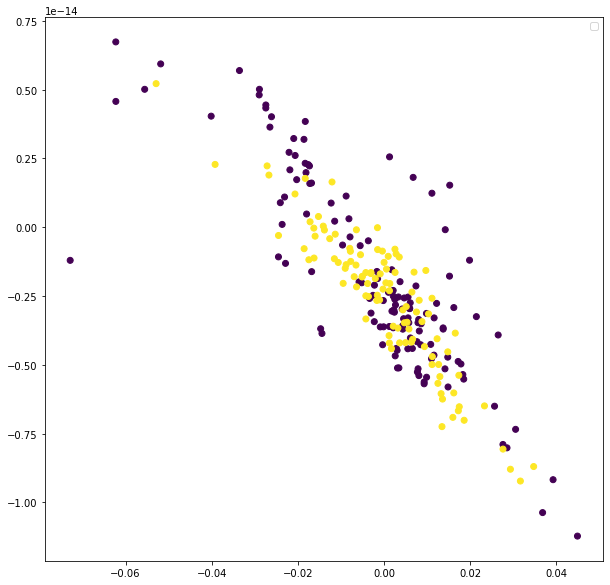

In [187]:
plt.figure(figsize=(10, 10))
plt.scatter(transformed_data.x, transformed_data.y, c=transformed_data.label)
plt.legend()

In [191]:
mnist = fetch_openml('mnist_784')

In [201]:
zero_one_data = mnist.data[(mnist.target == '0') | (mnist.target == '1')] / 255
zero_one_target = mnist.target[(mnist.target == '0') | (mnist.target == '1')]

In [202]:
zero_one_data.shape

(14780, 784)

In [203]:
zero_one_target.shape

(14780,)

In [229]:
noises = np.random.uniform(0, 1, zero_one_data.shape)

In [230]:
X = np.clip(zero_one_data + noises, 0, 1)

In [221]:
def draw(images, texts=None, columns=1, rows=1):
    fig = plt.figure(figsize=(3 * columns, 3 * rows))

    for i in range(columns * rows):
        ax = fig.add_subplot(rows, columns, i + 1)
        if texts is not None:
            ax.set_title(texts[i])
        ax.set_aspect('equal')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        plt.imshow(images[i].reshape(28, 28) * 255)

    cax = fig.add_axes([0.12, 0.1, 0.78, 0.8])
    cax.get_xaxis().set_visible(False)
    cax.get_yaxis().set_visible(False)
    cax.set_frame_on(False)
    plt.show()

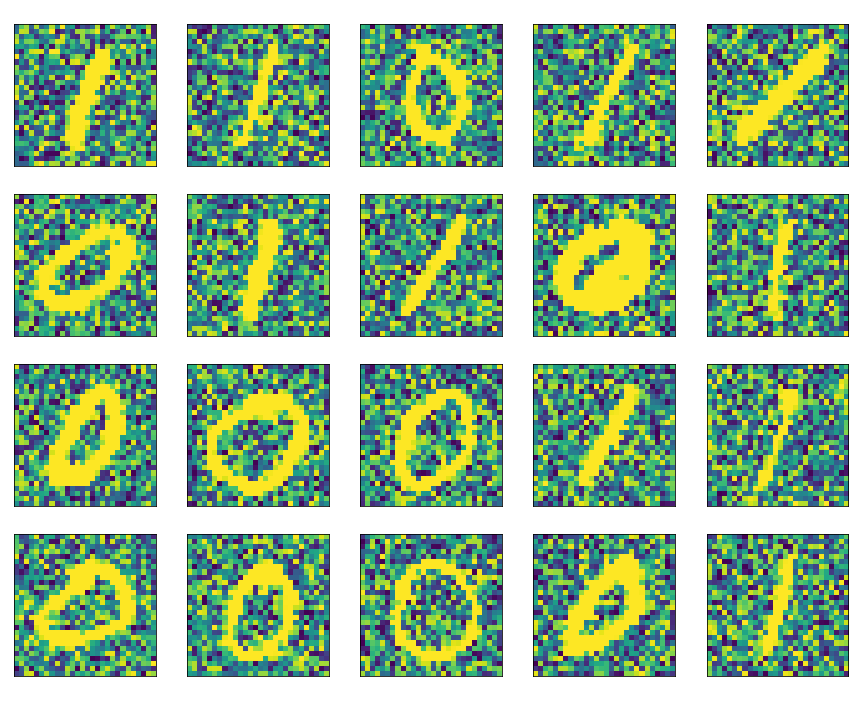

In [231]:
images = X[np.random.choice(np.arange(len(X)), size=20)]
draw(images, columns=5, rows=4)

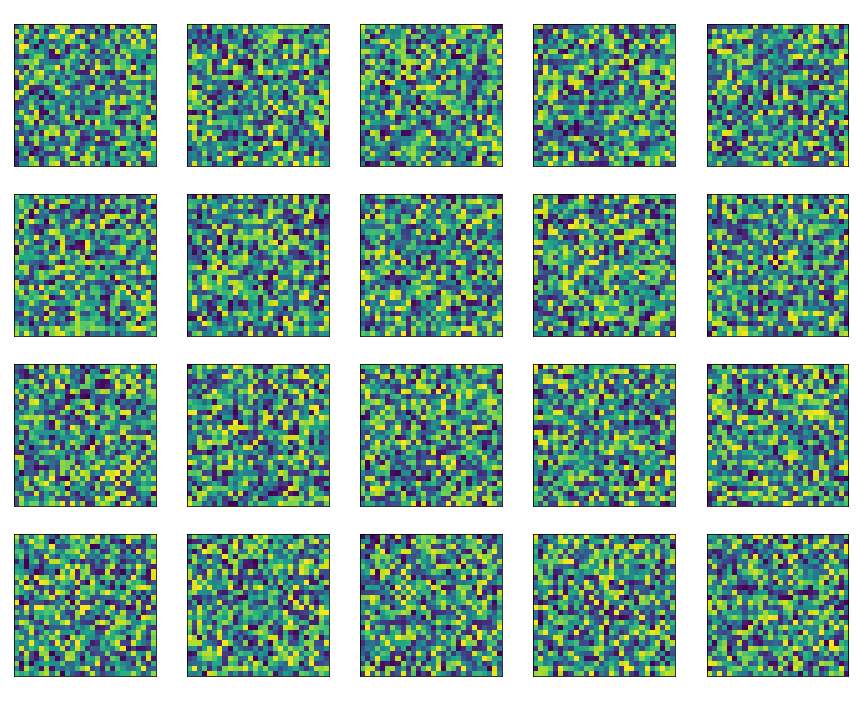

In [232]:
images = noises[np.random.choice(np.arange(len(noises)), size=20)]
draw(images, columns=5, rows=4)

In [242]:
alpha_set = np.arange(417, 420, 0.3)
alpha_set.size

10

In [243]:
alpha_star, V_star = cPCA(X, noises, alpha_set, k=2, p=1)

In [244]:
alpha_star[0]

418.20000000000005

In [245]:
X_transformed = X.dot(V_star[0])
X_transformed.shape

(14780, 2)

In [255]:
transformed_data = pd.DataFrame(X_transformed, columns=['x', 'y'])
transformed_data['label'] = ('10' + zero_one_target).astype('int32')
transformed_data.head()

,x,y,label
0,2.103007,2.192056,100
1,1.123786,1.633574,101
2,0.805976,1.624644,101
3,1.242671,1.219178,101
4,1.075998,1.184791,101


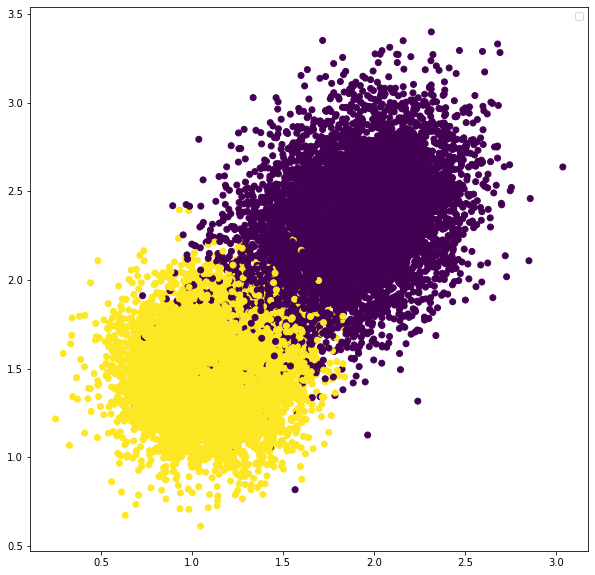

In [256]:
plt.figure(figsize=(10, 10))
plt.scatter(transformed_data.x, transformed_data.y, c=transformed_data.label)
plt.legend()

In [249]:
sum(transformed_data.label == '0')

6903